In [2]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

## Mediterranean Climate

The Mediterranean climate can be found on the West of the USA, in the state of California. The Mediterranean climate is characterized by a mild winter and summers. The average winter temperatures are around 15 degrees celcius, where the summer temperatures are on average 24 degrees celcius. Most of the rain falls from November to March. Snowfall is rare in the area. 

This well is situated near San Francisco on a height of 2.13 meters. The well is part of the California Coastal Basin aquifer system and it is classified as an confined aquifer. The water in the well is between 1 and 5 meters below the ground surface. The lithology of the well is unknown.


The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [54]:
map = folium.Map(location=[37.67, -122.16], zoom_start=6)
folium.Marker([37.66, -122.12], popup='Weather Station').add_to(map)
folium.Marker([37.67, -122.16], popup='Well').add_to(map);

In [55]:
map

### Importing Data

#### Seattle, Well 465033122570202
#### Groundwater series

In [3]:
height = 2.13 # meters above mean sea level

head_import = pd.read_csv('GW_Data/SanFrancisco_374004122092103.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

In [4]:
head 

Date and Time
2006-12-05   -1.152696
2007-04-02   -1.198416
2007-04-09   -1.527600
2007-04-26   -1.478832
2007-05-03   -1.771440
                ...   
2024-03-12    0.066504
2024-04-11   -0.055416
2024-06-26   -1.076496
2024-09-10   -1.338624
2024-10-29   -1.527600
Name: Value, Length: 3748, dtype: float64

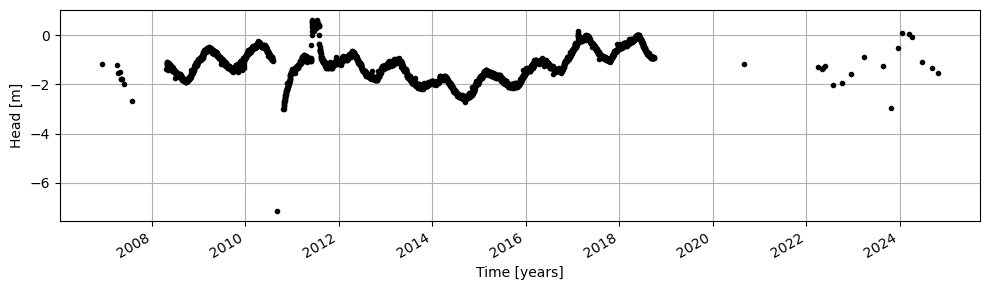

In [5]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

#### Precipitation

In [14]:
prec = pd.read_csv('Prec_temp/SanFrancisco_4008636.csv', delimiter=',', index_col=0, skiprows=0, usecols=[5, 6], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

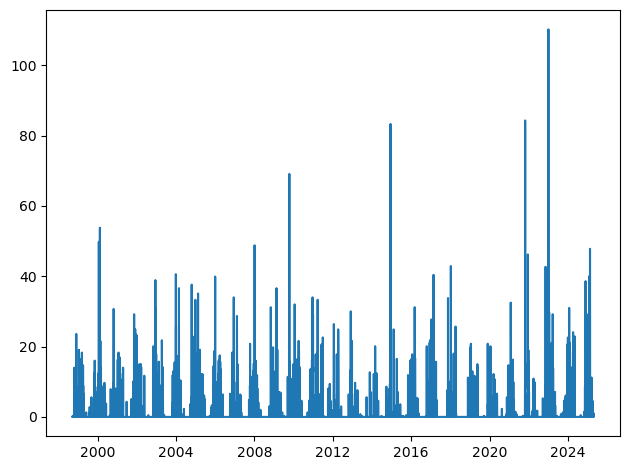

In [15]:
plt.plot(PRCP);

#### Evaporation

In [9]:
evap = pd.read_csv('Evap/SanFrancisco.csv', delimiter=',', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

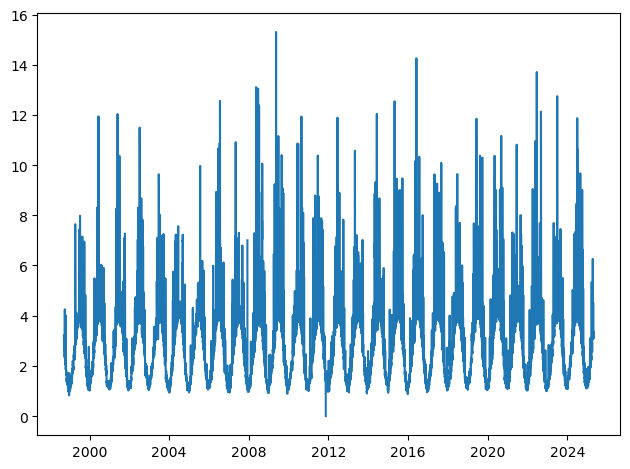

In [10]:
plt.plot(EPOT);

### Pastas Application

##### Validating the stresses

The stresses do not have a regular time step and therefore they need to be resampled with the help of Pandas

In [16]:
PRCP = PRCP.resample("24h", closed="right", label="right").mean()
EPOT = EPOT.resample("24h", closed="right", label="right").mean()

In [17]:
ps.validate_stress(EPOT)
ps.validate_stress(PRCP)

True

Now there are nan-values but those will be filled up with Pastas, so let's first create a basic pastas model

#### Basic Pastas Model

In [18]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'PRCP' was extended in the past to 1996-12-07 00:00:00 with the mean value (1.1) of the time series.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'Hargreaves' was extended in the past to 1996-12-07 00:00:00 with the mean value (2.9) of the time series.


Fit report Value                  Fit Statistics
nfev    32                     EVP         57.22
nobs    3748                   R2           0.57
noise   False                  RMSE         0.42
tmin    2006-12-05 00:00:00    AICc     -6534.80
tmax    2024-10-29 00:00:00    BIC      -6503.67
freq    D                      Obj        326.89
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         1.900414   0.210960  True
rch_n         1.081792   1.000000  True
rch_a       331.578596  10.000000  True
rch_f        -0.029694  -1.000000  True
constant_d   -2.802068  -1.214668  True


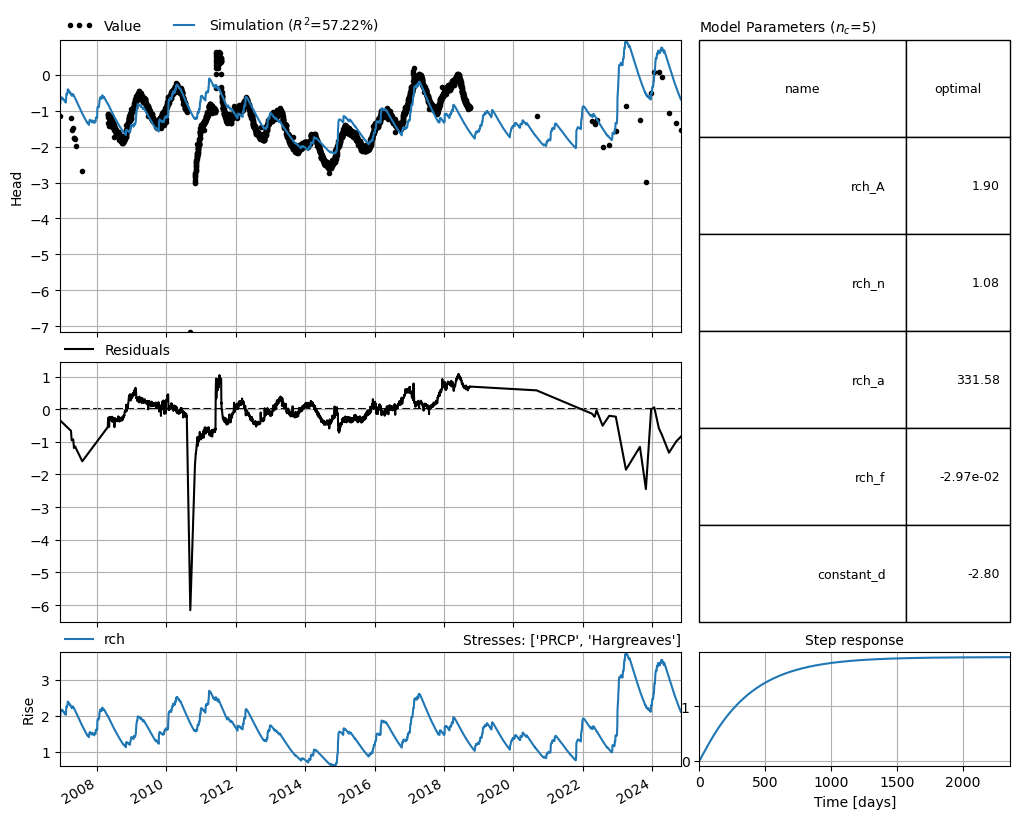

In [19]:
ml.plots.results();

#### Only take 2012-2018, as there is sparse data before and after these dates

In [28]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)

ml.solve(tmin='2011-08-01', tmax='2018-04-01')

INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    36                     EVP         75.67
nobs    2434                   R2           0.76
noise   False                  RMSE         0.30
tmin    2011-08-01 00:00:00    AICc     -5885.02
tmax    2018-04-01 00:00:00    BIC      -5856.06
freq    D                      Obj        108.01
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         2.216329   0.210960  True
rch_n         1.035088   1.000000  True
rch_a       367.442222  10.000000  True
rch_f        -0.058933  -1.000000  True
constant_d   -2.866361  -1.214668  True

Warnings! (1)
Response tmax for 'rch' > than calibration period.


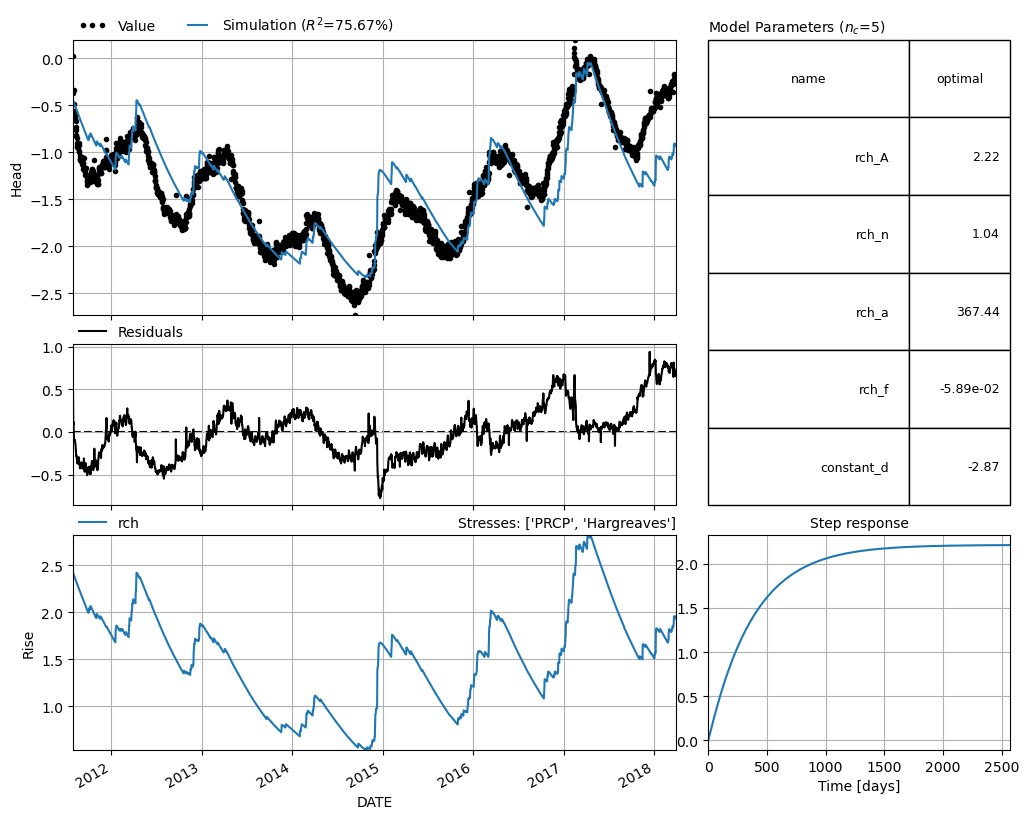

In [29]:
ml.plots.results();

#### Resample Monthly

In [30]:
head_resampled = head.resample('M').first()

In [31]:
head_resampled

Date and Time
2006-12-31   -1.152696
2007-01-31         NaN
2007-02-28         NaN
2007-03-31         NaN
2007-04-30   -1.198416
                ...   
2024-06-30   -1.076496
2024-07-31         NaN
2024-08-31         NaN
2024-09-30   -1.338624
2024-10-31   -1.527600
Freq: M, Name: Value, Length: 215, dtype: float64

In [32]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve(tmin='2011-08-01', tmax='2018-04-01')

INFO: Time Series 'Value': 69 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    29                     EVP        80.57
nobs    80                     R2          0.81
noise   False                  RMSE        0.27
tmin    2011-08-01 00:00:00    AICc     -200.71
tmax    2018-04-01 00:00:00    BIC      -189.61
freq    D                      Obj         2.84
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         2.284754   0.210960  True
rch_n         1.336940   1.000000  True
rch_a       274.545810  10.000000  True
rch_f        -0.108373  -1.000000  True
constant_d   -2.572756  -1.283802  True


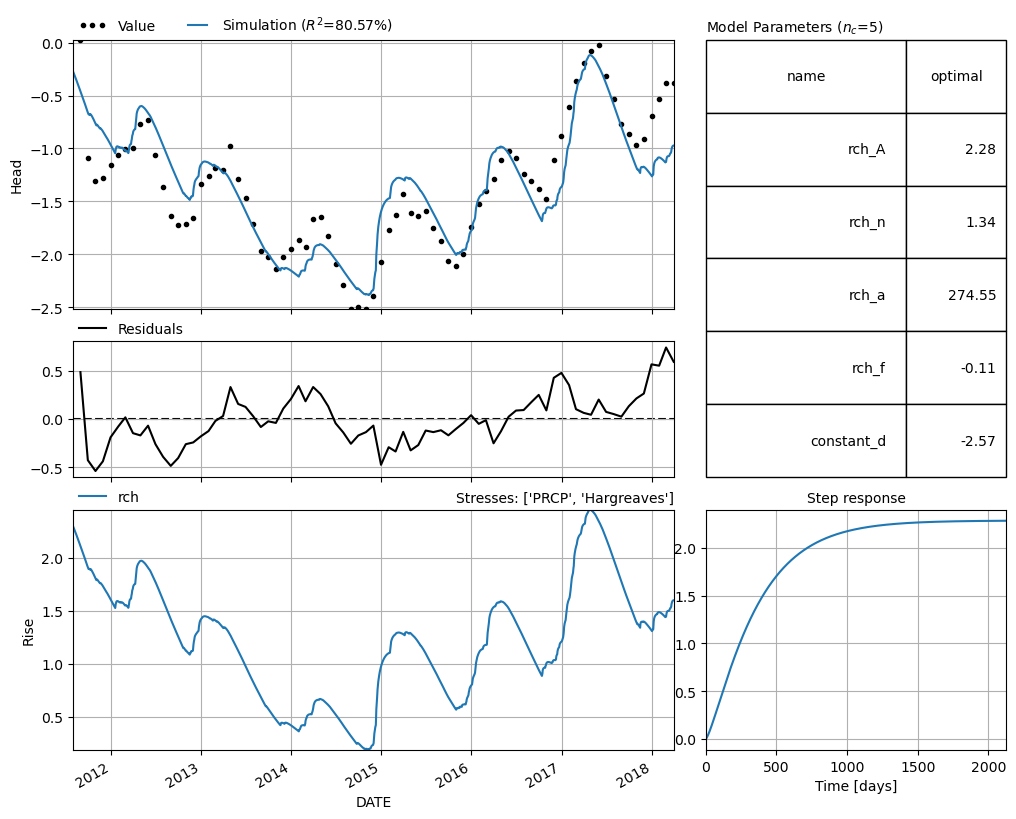

In [33]:
ml.plots.results();

### Try out different response functions and recharge models

In [43]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel())
ml.add_stressmodel(sm)
ml.solve(tmin='2011-08-01', tmax='2018-04-01')

INFO: Time Series 'Value': 69 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    26                     EVP        6.86
nobs    80                     R2         0.07
noise   False                  RMSE       0.58
tmin    2011-08-01 00:00:00    AICc     -70.56
tmax    2018-04-01 00:00:00    BIC      -55.44
freq    D                      Obj       13.63
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (7 optimized)
                optimal     initial   vary
rch_A          0.293018    0.661122   True
rch_n          0.184099    1.000000   True
rch_a          3.994499   10.000000   True
rch_srmax    976.036396  250.000000   True
rch_lp         0.250000    0.250000  False
rch_ks      2955.955010  100.000000   True
rch_gamma      2.931024    2.000000   True
rch_kv         1.000000    1.000000  False
rch_simax      2.000000    2.000000  False
constant_d    -1.436078   -1.283802   True


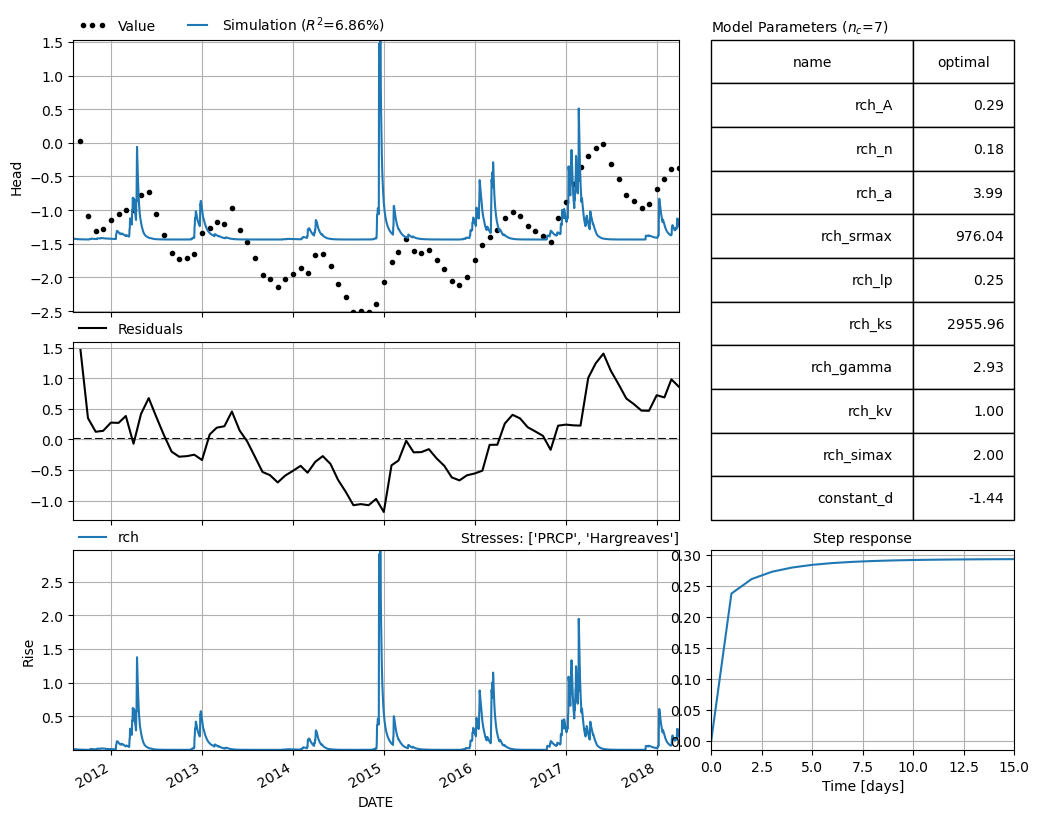

In [44]:
ml.plots.results();

In [50]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)
ml.solve(tmin='2011-08-01', tmax='2018-04-01')

INFO: Time Series 'Value': 69 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    73                     EVP        89.56
nobs    80                     R2          0.90
noise   False                  RMSE        0.20
tmin    2011-08-01 00:00:00    AICc     -240.62
tmax    2018-04-01 00:00:00    BIC      -221.76
freq    D                      Obj         1.53
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (9 optimized)
               optimal    initial  vary
rch_A        14.868705   1.176185  True
rch_n         1.298750   1.000000  True
rch_a       278.295344  10.000000  True
rch_scap      1.600887   1.500000  True
rch_alpha     1.115726   1.000000  True
rch_ksat      0.269289   1.000000  True
rch_beta      0.283623   0.500000  True
rch_gamma     0.814044   1.000000  True
constant_d   -3.204920  -1.283802  True


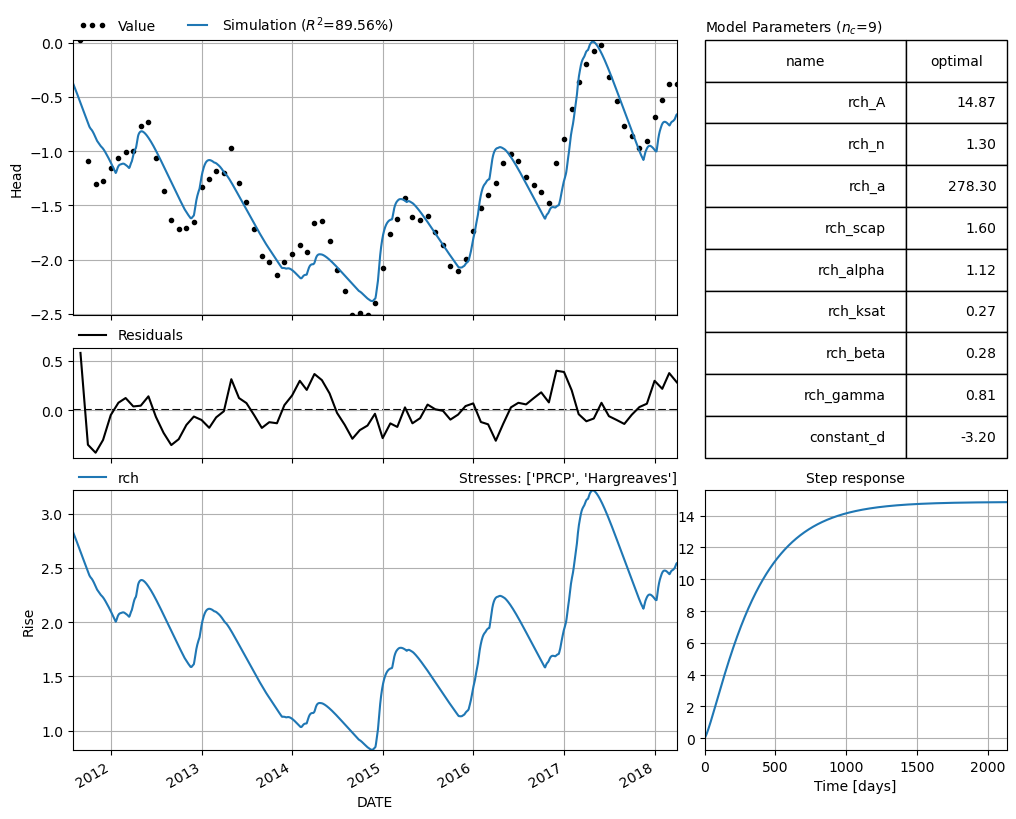

In [51]:
ml.plots.results();

The groundwater is quite close to the surface and therefore the gw_uptake=True feature could improve the model.

#### Groundwater uptake is true

In [47]:
ml1 = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml1.add_stressmodel(sm)
ml1.solve(tmin='2011-08-01', tmax='2018-04-01')

INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 9 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 52 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    57                     EVP         76.45
nobs    2434                   R2           0.76
noise   False                  RMSE         0.29
tmin    2011-08-01 00:00:00    AICc     -5958.23
tmax    2018-04-01 00:00:00    BIC      -5911.91
freq    D                      Obj        104.55
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (8 optimized)
               optimal     initial   vary
rch_A         3.582387    0.354336   True
rch_n         1.064832    1.000000   True
rch_a       429.708730   10.000000   True
rch_srmax   132.780006  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks      182.644099  100.000000   True
rch_gamma     2.226848    2.000000   True
rch_kv        1.000000    1.000000  False
rch_simax     2.000000    2.000000  False
rch_gf        0.073789    1.000000   True
constant_d   -2.430389   -1.214668   True

Warnings! (1)
Response tmax 

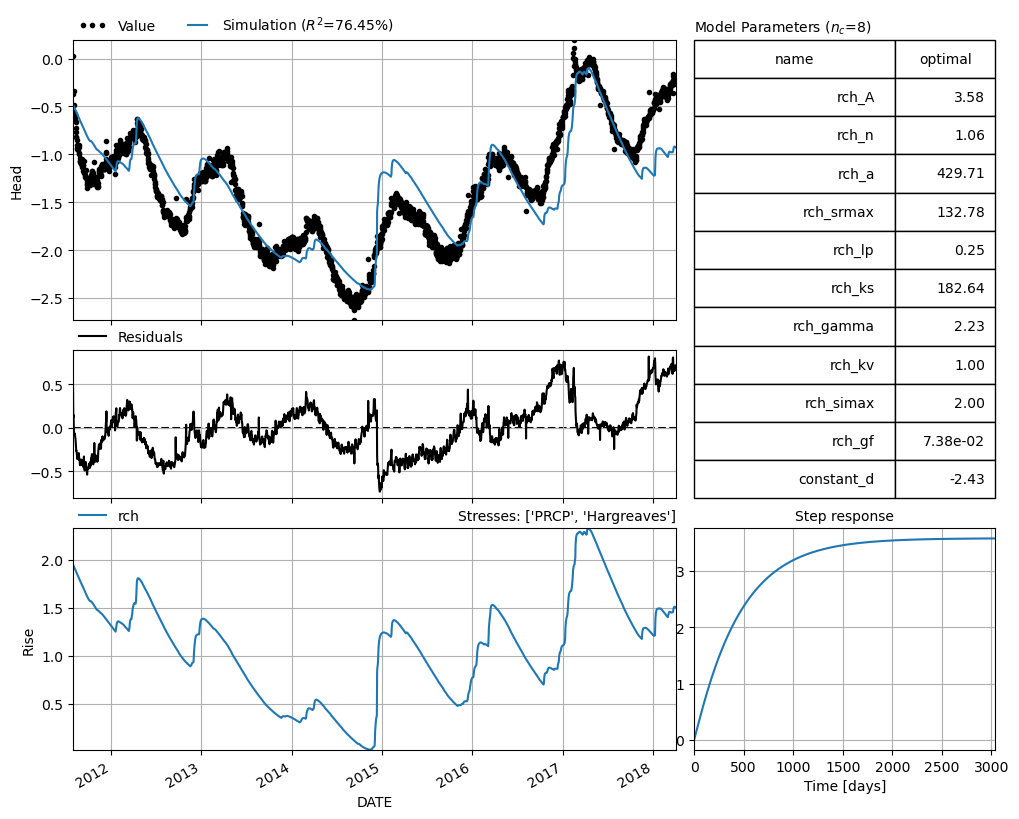

In [48]:
ml1.plots.results();

However, in this case the Peterson Recharge function might be a better fit.

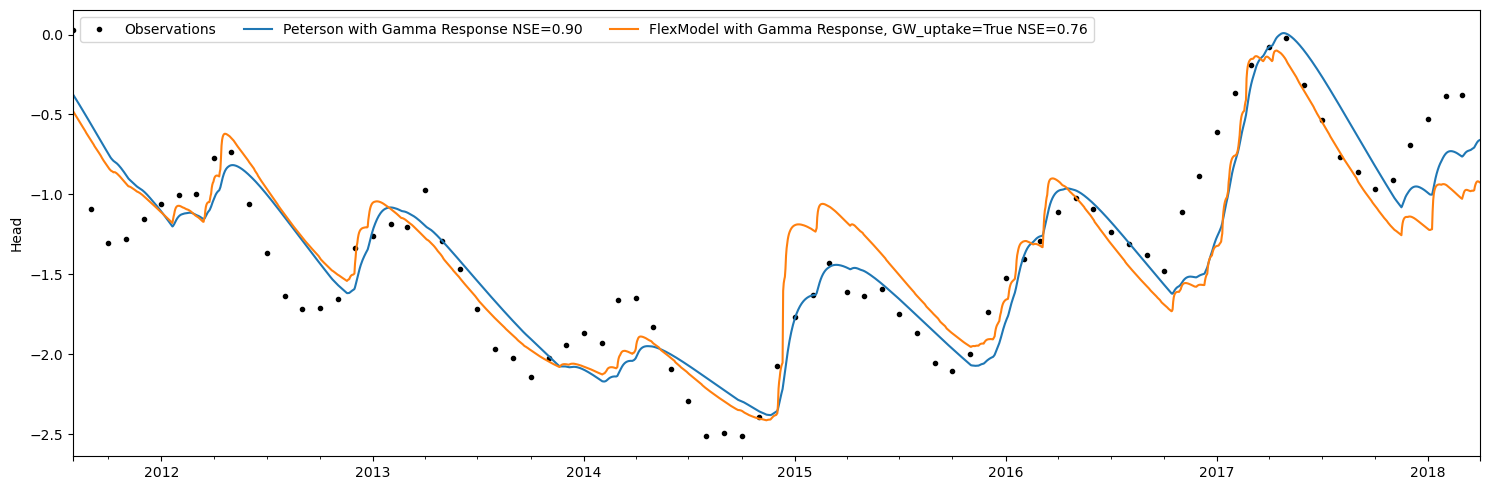

In [52]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "Peterson with Gamma Response NSE={:.2f}".format(ml.stats.nse()),
        "FlexModel with Gamma Response, GW_uptake=True NSE={:.2f}".format(ml1.stats.nse()),
    ],
    ncol=3,
)